In [ ]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch_cuda.device_count()}")
    print(f"GPU Name: {torch_cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch_cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch_cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')
torch.cuda.manual_seed(42)
torch.manual_seed(42)

===VERIFY GPU===
CUDA IS AVAILABLE: True
DEVICE COUNT: 1
DEVICE NAME: NVIDIA RTX A4000
Number of GPUs: 1
GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes


## Dataset

In [3]:
# Define hyperparameters
batch_size = 32

# Define transformations: Convert to tensor and normalize
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

mnist_trainset = datasets.MNIST(
    root='../Data',
    train=True,
    download=True,
    transform=transformations
)

mnist_testset = datasets.MNIST(
    root='../Data',
    train=False,
    download=True,
    transform=transformations
)

trainloader = DataLoader(
    mnist_trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = DataLoader(
    mnist_testset,
    batch_size=batch_size,
    shuffle=False,
)

## CNN

In [ ]:
momentum_coeff = 0.9
learning_rate = 0.01
learning_decay = 10**-9
epochs = 100

In [ ]:
# Define a multi-layer perceptron (MLP) mode

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2) 
        self.dropout1 = nn.Dropout(0.25) 

        # Second convolutional block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  
        self.pool2 = nn.MaxPool2d(kernel_size=2)  
        self.dropout2 = nn.Dropout(0.25)  

        # Fully connected layers
        self.fc1 = nn.Linear(3136, 3136)  
        self.dropout3 = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(3136, 512)
        self.out = nn.Linear(512, 10) 

    def forward(self, x, output = 3):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = x.view(-1, 64 * 7 * 7)

        x = F.relu(self.fc1(x))
        if output == 1:
            return x
        x = self.dropout3(x)
        
        x = F.relu(self.fc2(x))
        if output == 2:
            return x

        x = self.out(x) 
        return x


# Instantiate and move model to the selected device
cnn = CNN().to(device)

loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss expects raw logits
optimizer = optim.SGD(cnn.parameters(), lr=learning_rate,
                      momentum=momentum_coeff, weight_decay=learning_decay)


def train(epoch):

    cnn.train()
    for batch_idx, (data, target) in enumerate(trainloader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = cnn(data, output=3)

        loss = loss_function(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 25 == 0:
            print('Train Epoch: {:>3}\t[{:>5}/{:>5} ({:>3.0f}%)]\tLoss: {:>7.6f}'.format(
                epoch + 1, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))


def test():
    cnn.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in testloader:

            data, target = data.to(device), target.to(device)

            output = cnn(data, output=3)

            test_loss += loss_function(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)

            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testloader)

    print('\nTest set: Average loss: {:>10.4f}, Accuracy: {:>5}/{:>5} ({:>3.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


for epoch in range(epochs):
    train(epoch)
    test()

Train Epoch:   1	[    0/60000 (  0%)]	Loss: 2.303550
Train Epoch:   1	[  800/60000 (  1%)]	Loss: 2.308923
Train Epoch:   1	[ 1600/60000 (  3%)]	Loss: 2.292470
Train Epoch:   1	[ 2400/60000 (  4%)]	Loss: 2.321319
Train Epoch:   1	[ 3200/60000 (  5%)]	Loss: 2.305524
Train Epoch:   1	[ 4000/60000 (  7%)]	Loss: 2.317113
Train Epoch:   1	[ 4800/60000 (  8%)]	Loss: 2.284805
Train Epoch:   1	[ 5600/60000 (  9%)]	Loss: 2.221175
Train Epoch:   1	[ 6400/60000 ( 11%)]	Loss: 1.238682
Train Epoch:   1	[ 7200/60000 ( 12%)]	Loss: 0.904921
Train Epoch:   1	[ 8000/60000 ( 13%)]	Loss: 0.618016
Train Epoch:   1	[ 8800/60000 ( 15%)]	Loss: 0.681959
Train Epoch:   1	[ 9600/60000 ( 16%)]	Loss: 0.465374
Train Epoch:   1	[10400/60000 ( 17%)]	Loss: 0.423406
Train Epoch:   1	[11200/60000 ( 19%)]	Loss: 0.322860
Train Epoch:   1	[12000/60000 ( 20%)]	Loss: 0.239251
Train Epoch:   1	[12800/60000 ( 21%)]	Loss: 0.075157
Train Epoch:   1	[13600/60000 ( 23%)]	Loss: 0.123804
Train Epoch:   1	[14400/60000 ( 24%)]	Loss: 0.

In [6]:
torch.save(cnn.state_dict(), '../Saved/MNIST_CNN_TRAINED.pt')

In [44]:
def get_activations(layer = 2):
    activations = []
    labels = []
    predictions = []
    with torch.no_grad():

        #  Train Data Activations
        for data, target in trainloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = cnn(data, output=layer)
            for t in output:
                activations.append(t.to('cpu').numpy())
            labels.append(target.to('cpu').numpy())

            output = cnn(data, output=3)
            for t in output:
                pred = np.argmax(t.to('cpu').numpy())
                predictions.append(pred)

        #  Test Data Activations
        for data, target in testloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = cnn(data, output=layer)
            for t in output:
                activations.append(t.to('cpu').numpy())
            target_arr = target.to('cpu').numpy()
            if len(target_arr) != 32:
                target_arr = np.pad(target_arr, (0, 32 - len(target_arr)), mode='constant', constant_values=-1)
            labels.append(target_arr)

            output = cnn(data, output=3)
            for t in output:
                pred = np.argmax(t.to('cpu').numpy())
                predictions.append(pred)

    return activations, labels, predictions

activations_l2, labels_l2, predictions_l2 = get_activations(2)
activations_l1, labels_l1, predictions_l1 = get_activations(1)

In [45]:
activations_l1 = np.array(activations_l1)
predictions_l1_df = pd.DataFrame(predictions_l1, columns=['prediction'])
labels_l1_df = pd.DataFrame(np.array(labels_l1).flatten()[:70000], columns=['class'])

activations_l2 = np.array(activations_l2)
predictions_l2_df = pd.DataFrame(predictions_l2, columns=['prediction'])
labels_l2_df = pd.DataFrame(np.array(labels_l2).flatten()[:70000], columns=['class'])


### Dimensionality Reduction

In [46]:
print('DENSE LAYER ONE:', activations_l1.shape)
print('DENSE LAYER TWO:', activations_l2.shape)

DENSE LAYER ONE: (70000, 3136)
DENSE LAYER TWO: (70000, 512)


In [47]:
from sklearn.manifold import TSNE

dim_red1 = TSNE(n_components = 2, random_state=0)
points_l1 = dim_red1.fit_transform(activations_l1)

dim_red2 = TSNE(n_components = 2, random_state=0)
points_l2 = dim_red2.fit_transform(activations_l2)

In [49]:
# Quick plot to check data
points_l1_df = pd.DataFrame(points_l1, columns=['x','y']).join(labels_l1_df).join(predictions_l1_df)
points_l2_df = pd.DataFrame(points_l2, columns=['x','y']).join(labels_l2_df).join(predictions_l2_df)

### Quick Plot

<Axes: xlabel='x', ylabel='y'>

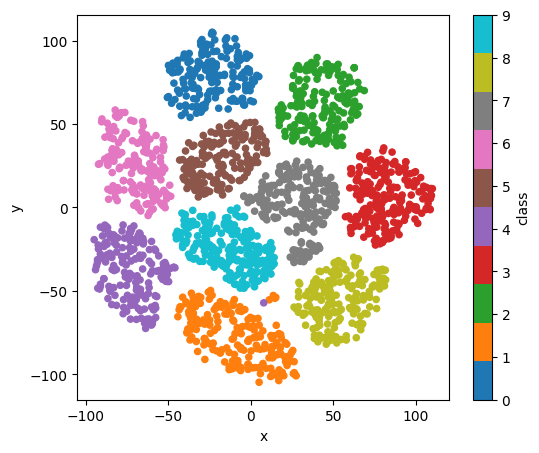

In [50]:
plt.rcParams["figure.figsize"] = [6, 5]

points_l1_df[0:2000].plot.scatter(
    x='x',
    y='y',
    c='class',
    colormap='tab10'
)

<Axes: xlabel='x', ylabel='y'>

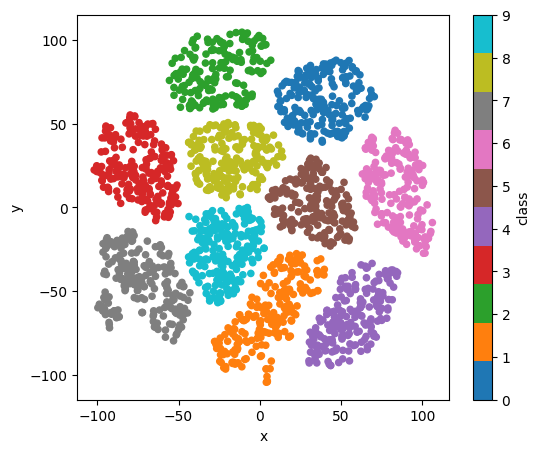

In [51]:

points_l2_df[0:2000].plot.scatter(
    x='x',
    y='y',
    c='class',
    colormap='tab10'
)

In [52]:
points_l1_df.to_csv('../Outputs/MNIST_CNN_LAYER_2_WITH_PREDICTIONS_2.csv', index=False)
points_l2_df.to_csv('../Outputs/MNIST_CNN_LAYER_3_WITH_PREDICTIONS_2.csv', index=False)